# Automation

# Data Understanding

,user_id,show_id,rating
0,1,8381,4
1,1,3466,5
2,1,3181,4
3,1,294,3
4,1,7739,5


,show_id,type,title,director,cast,country,release_year,rating,duration,description,...,Language TV Shows,Musicals,Nature TV,Reality TV,Spirituality,TV Action,TV Comedies,TV Dramas,Talk Shows TV Comedies,Thrillers
0,1,Movie,Dick Johnson Is Dead,Kirsten Johnson,"Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...",United States,2020,PG-13,90 min,As her father nears the end of his life filmma...,...,0,0,0,0,0,0,0,0,0,0
1,2,TV Show,Blood & Water,NaN,Ama Qamata Khosi Ngema Gail Mabalane Thabang M...,South Africa,2021,TV-MA,2 Seasons,After crossing paths at a party a Cape Town te...,...,0,0,0,0,0,0,0,1,0,0
2,3,TV Show,Ganglands,Julien Leclercq,Sami Bouajila Tracy Gotoas Samuel Jouy Nabiha ...,NaN,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,...,0,0,0,0,0,1,0,0,0,0
3,4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021,TV-MA,1 Season,Feuds flirtations and toilet talk go down amon...,...,0,0,0,1,0,0,0,0,0,0
4,5,TV Show,Kota Factory,NaN,Mayur More Jitendra Kumar Ranjan Raj Alam Khan...,India,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,...,0,0,0,0,0,0,1,0,0,0


,user_id,name,phone,email,age,gender,Netflix,Amazon Prime,Disney+,Paramount+,Max,Hulu,Apple TV+,Peacock,city,state,zip
0,1,Stephen Peters,890.309.2971,esmith@hotmail.com,18,Male,0,0,0,1,0,1,1,0,New John,CT,53771
1,2,Vicki Thomas,399.837.0996,callahanmichael@gmail.com,51,Female,0,0,1,0,0,0,1,1,Lake Robert,TN,71689
2,3,Jesse Bright,(268)691-6431,acline@shelton.biz,30,Female,0,0,0,1,0,0,0,1,East Tinaside,ME,40660
3,4,Mark Hernandez,+1-473-252-5923x513,deborah33@yahoo.com,22,Male,0,1,1,0,1,0,1,1,Bowenchester,VA,17039
4,5,Cynthia Armstrong,001-015-883-2813x8196,amycastillo@larsen.com,40,Female,1,0,1,1,1,0,1,0,North Thomasland,GA,77006


(2147, 3) (8508, 42) (200, 17)
Number of ratings: 2147
Number of unique movieId's: 1809
Number of unique users: 200
Average ratings per user: 10.73
Average ratings per movie: 1.19
Counts of how many times each movie was rated count
1    1514
2     258
3      31
4       6
Name: count, dtype: int64
Spread of the count shows were rated: 
Min:		 1
Quartile 1:	 1.0
Median:		 1.0
Quartile 3:	 1.0
Max:		 4
Duplicate ratings: 0
Nulls of each column in user: user_id         0
name            0
phone           0
email           0
age             0
gender          0
Netflix         0
Amazon Prime    0
Disney+         0
Paramount+      0
Max             0
Hulu            0
Apple TV+       0
Peacock         0
city            0
state           0
zip             0
dtype: int64


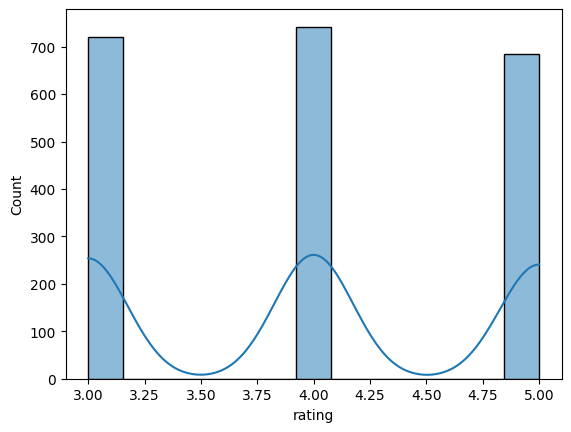

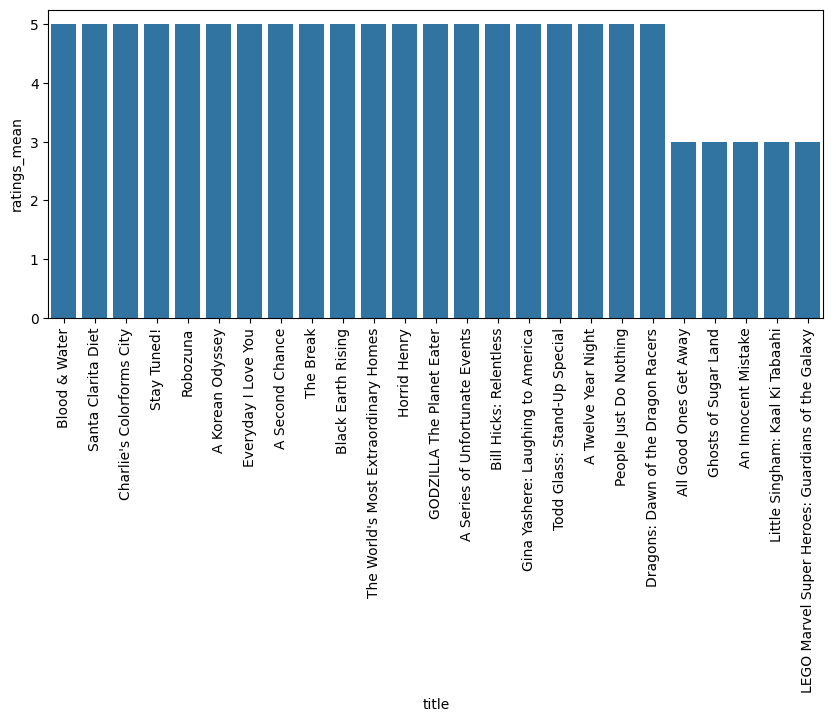

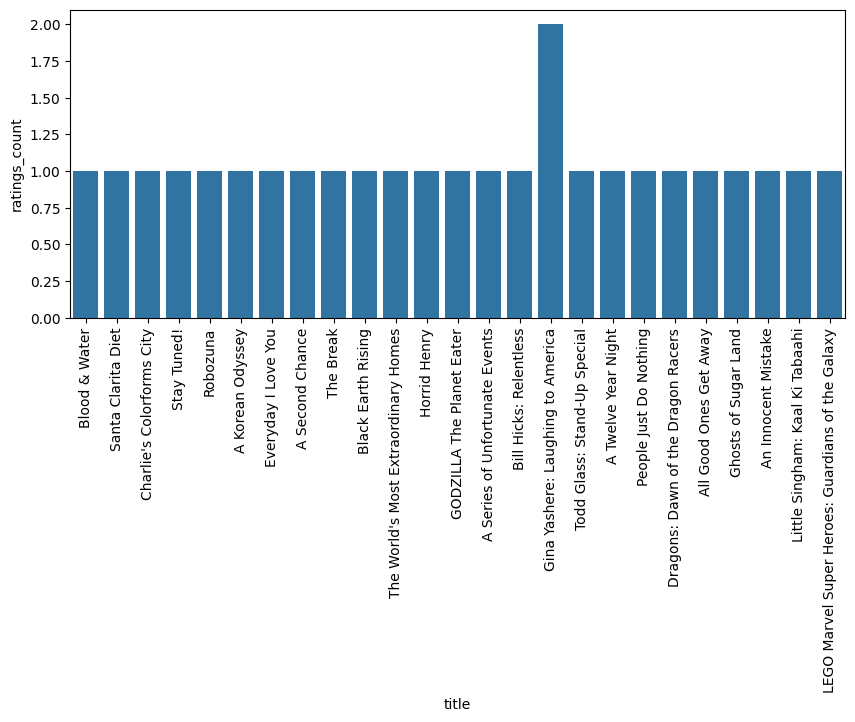

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sqlalchemy import create_engine
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import train_test_split

df_ratings = pd.read_csv('movies_ratings.csv')
df_titles = pd.read_csv('movies_titles.csv')
df_users = pd.read_csv('movies_users.csv')

display(df_ratings.head())
display(df_titles.head())
display(df_users.head())
print(df_ratings.shape, df_titles.shape, df_users.shape)

sns.histplot(data=df_ratings, x='rating', kde=True)

n_ratings = len(df_ratings)
n_movies = len(df_ratings['show_id'].unique())
n_users = len(df_ratings['user_id'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")
print(f"Counts of how many times each movie was rated {df_ratings['show_id'].value_counts().value_counts()}")

print('Spread of the count shows were rated: ')
print('Min:\t\t', df_ratings['show_id'].value_counts().min())
print('Quartile 1:\t', df_ratings['show_id'].value_counts().quantile(.25))
print('Median:\t\t', df_ratings['show_id'].value_counts().quantile(.5))
print('Quartile 3:\t', df_ratings['show_id'].value_counts().quantile(.75))
print('Max:\t\t', df_ratings['show_id'].value_counts().max())

print(f"Duplicate ratings: {df_ratings.duplicated(subset=['user_id', 'show_id']).sum()}")
print(f'Nulls of each column in user: {df_users.isna().sum()}')

# Visualize the average rating for each movie

# Group the rows into individual titles and calculate the mean rating for each row
movie_stats = df_ratings.groupby(by=['show_id'])[['rating']].agg(['count', 'mean'])
movie_stats.columns = ['ratings_count', 'ratings_mean'] # Rename the columns to simplify the index

# Join with df_titles to get the titles
movie_stats = movie_stats.reset_index().merge(
    df_titles[['show_id', 'title']], 
    on='show_id', 
    how='left'
)

# Sort the ratings
movie_stats = movie_stats.sort_values(by=['ratings_mean'], ascending=False)

# Create a smaller dataset of the top n and bottom n rated movies
df_reduced = pd.concat([movie_stats.head(20), movie_stats.tail(5)])

plt.figure(figsize=(10,4)) # Set the size of the figure
sns.barplot(data=df_reduced, x='title', y='ratings_mean')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10,4)) # Set the size of the figure
sns.barplot(data=df_reduced, x='title', y='ratings_count')
plt.xticks(rotation=90)
plt.show()

# Data Preparation

In [107]:
df_titles.drop('director', axis=1, inplace=True)
df_titles.dropna(inplace=True)
# Make sure that the ratings dataframe includes only the shows that weren't deleted from dropping empty rows
common_ids = set(df_titles['show_id']).intersection(set(df_ratings['show_id']))
df_titles = df_titles[df_titles['show_id'].isin(common_ids)]
df_ratings = df_ratings[df_ratings['show_id'].isin(common_ids)]

# Prep user dataframe for use
df_users.drop(columns=['city','state','zip','email','name','phone'])

# To help with cold start problem, here's beysian math transformation
# Step 1: Compute global average rating (C)
C = df_ratings['rating'].mean()

# Step 2: Compute number of ratings and average rating per movie
movie_stats = df_ratings.groupby('show_id').agg(
    v=('rating', 'count'),  # number of ratings
    R=('rating', 'mean')    # average rating
).reset_index()

# Step 3: Choose a minimum number of ratings threshold (m)
m = 1  # tweak this based on your dataset

# Step 4: Compute Bayesian average
movie_stats['bayesian_rating'] = (
    (movie_stats['v'] / (movie_stats['v'] + m)) * movie_stats['R']
    + (m / (movie_stats['v'] + m)) * C
)

# Step 5: Merge back and overwrite the 'rating' column
df_ratings = df_ratings.merge(
    movie_stats[['show_id', 'bayesian_rating']],
    on='show_id',
    how='left'
)

df_ratings['rating'] = df_ratings['bayesian_rating']
df_ratings.drop(columns=['bayesian_rating'], inplace=True)

# Modeling and Evaluation

### Collaborative

In [108]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[['user_id', 'show_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

sim_options = {
    'name': 'cosine',         # or 'pearson'
    'user_based': True,       # set to False for item-based
    'min_support': 1,         # minimum common items required
    'verbose': True
}

algo = SVD()
algo.fit(trainset)

### Content (with some extra data prep)

In [109]:
genre_cols = [col for col in df_titles.columns if df_titles[col].dtype == 'int64' and col not in ['release_year']]

# Create feature matrix: genre dummies + normalized release_year + rating encoding
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Normalize release_year
scaler = MinMaxScaler()
df_titles['release_year_scaled'] = scaler.fit_transform(df_titles[['release_year']].fillna(0))

# One-hot encode 'rating' column
rating_encoded = pd.get_dummies(df_titles['rating'].fillna('Unknown'), prefix='rating')

# Final feature matrix
feature_matrix = pd.concat([
    df_titles[genre_cols],
    df_titles[['release_year_scaled']],
    rating_encoded
], axis=1)

feature_matrix.index = df_titles['show_id']
content_similarity = cosine_similarity(feature_matrix)
content_sim_df = pd.DataFrame(content_similarity, index=feature_matrix.index, columns=feature_matrix.index)



### Content on Genre and past user ratings

In [110]:
# Step 1: Identify genre columns
genre_cols = [col for col in df_titles.columns if df_titles[col].dropna().isin([0, 1]).all() and col not in ['release_year']]
genre_cols = [col for col in genre_cols if df_titles[col].sum() > 0]  # remove any columns with all 0s

# Step 2: Merge with ratings to limit to rated content (if desired)
df_full = df_titles[df_titles['show_id'].isin(df_ratings['show_id'])].copy()
df_full = df_full.reset_index(drop=True)

# Step 3: Compute cosine similarity on genre vectors
from sklearn.metrics.pairwise import cosine_similarity
genre_matrix = df_full[genre_cols].fillna(0).values
cosine_sim = cosine_similarity(genre_matrix)

# Step 4: Build recommendation entries
recs = []
for idx, row in df_full.iterrows():
    show_id = row['show_id']
    genres = [g for g in genre_cols if row[g] == 1]
    genre_string = ', '.join(genres)

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]  # skip self

    for rec_idx, score in sim_scores:
        recs.append({
            'show_id': show_id,
            'recommended_id': df_full.at[rec_idx, 'show_id'],
            'genre': genre_string,
            'score': float(score)
        })

# Step 5: Convert to DataFrame
df_genre_recs = pd.DataFrame(recs)

# Deployment

### First, we have a collabortively trained deployment based on user_id

In [111]:
# Get list of all user_ids and show_ids from the training set
# Get mappings from inner to raw IDs
user_inner_to_raw = trainset.to_raw_uid
item_inner_to_raw = trainset.to_raw_iid

all_user_ids = trainset.all_users()
all_item_ids = trainset.all_items()
top_n = 25  # top-N recommendations per user

rows = []

for inner_uid in all_user_ids:
    raw_uid = int(user_inner_to_raw(inner_uid))
    
    # Get items already rated
    rated_items = set(item_inner_to_raw(iid) for (iid, _) in trainset.ur[inner_uid])
    
    preds = []
    for inner_iid in all_item_ids:
        raw_iid = item_inner_to_raw(inner_iid)
        if raw_iid not in rated_items:
            pred = algo.predict(str(raw_uid), str(raw_iid))
            preds.append((raw_iid, pred.est))
    
    # Get top-N
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
    
    for show_id, score in top_preds:
        rows.append({
            'show_id': show_id,
            'distance': round(score, 3),
            'user_id': raw_uid
        })

engine = create_engine('sqlite:///recommender.db')

df_top10_user = pd.DataFrame(rows)
df_top10_user.to_sql(
    'top10_userId', 
    con=engine, 
    if_exists='replace',  # or 'append' if you want to keep old rows
    index=False
)

5000

### Content deployment of shows, based on genre, year, and rating

In [112]:
content_sim_df_reset = content_sim_df.reset_index()  # 'show_id' becomes a column

engine = create_engine('sqlite:///recommender.db')

content_sim_df_reset.to_sql('content_recs1', con=engine, if_exists='replace', index=False)

1592

### Deployment of genre based on user ratings show recommendations

In [113]:

# Step 1: Create SQLAlchemy engine for SQLite
engine = create_engine('sqlite:///recommender.db')

# Step 2: Write DataFrame to the genre_recommendations table
df_genre_recs.to_sql('genre_recommendations', con=engine, if_exists='replace', index=False)


7960